# Grokking

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/grokking.ipynb)

In [ ]:
%pip install devinterp seaborn wandb

In [9]:
from dataclasses import dataclass
from itertools import product
import logging
import os
from pathlib import Path
import time
from typing import Callable, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydantic import BaseModel
import seaborn as sns
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from tqdm import tqdm
import wandb

from devinterp.slt import estimate_learning_coeff
from devinterp.zoo.arithmetic import ModularArithmeticConfig, ModularArithmetic
from devinterp.zoo.transformer import TransformerConfig
from devinterp.optim.sgld import SGLD

logging.basicConfig(level=logging.INFO)

sns.set_palette("deep")
sns.set_style("whitegrid")

CHECKPOINTS_PATH = Path("../checkpoints/grokking")

if not os.path.exists(CHECKPOINTS_PATH):
    os.makedirs(CHECKPOINTS_PATH)

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("deep")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("muted")[:3]

DEVICE = os.environ.get(
    "DEVICE",
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu",
)
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

# wandb
PROJECT = os.environ.get("PROJECT", "grokking")
ENTITY = os.environ.get("ENTITY", "devinterp")
# ENTITY = None
USE_WANDB = bool(PROJECT and ENTITY)

DEVICE, NUM_CORES, PROJECT, ENTITY, USE_WANDB

(device(type='cuda', index=0), 1, 'grokking', 'devinterp', True)

In [10]:
# Evals


def cross_entropy_last_token(outputs, targets, reduction="sum"):
    """
    Wrapper around cross entropy loss because we only care about the last number predicted.
    """
    # Only look at predictions of last numbers
    outputs = outputs[:, -1]

    # Compute individual and summed losses for final number
    logprobs = F.log_softmax(outputs.to(torch.float32), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=targets.unsqueeze(1), dim=-1)

    if reduction == "mean":
        loss = -torch.mean(prediction_logprobs)
    elif reduction == "sum":
        loss = -torch.sum(prediction_logprobs)
    else:
        raise ValueError("Invalid reduction argument.")

    return loss


def make_evals(trainset: ModularArithmetic, testset: ModularArithmetic, device: str):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

    def eval_loss_and_acc(model: nn.Module) -> Dict[str, float]:
        model.eval()

        results = {}

        for name, loader in zip(["train", "test"], [trainloader, testloader]):
            total = 0
            correct = 0

            for x, y in loader:
                x = x.to(device)
                y = y.to(device)

                with torch.no_grad():
                    y_hat = model(x)

                total += cross_entropy_last_token(y_hat, y, reduction="sum").item()
                correct += (
                    (y_hat[:, -1, :].max(dim=1).indices == y).sum().item()
                )  # argmax doesn't work for device=mps

            results[f"{name}/loss"] = total / len(loader.dataset)
            results[f"{name}/accuracy"] = correct / len(loader.dataset)

        return results

    return eval_loss_and_acc

In [11]:
@dataclass
class Learner:
    config: "GrokkingConfig"
    model: nn.Module
    dataset: torch.utils.data.Dataset
    loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Optimizer
    evals: Callable[[nn.Module], Dict[str, float]]


class GrokkingConfig(BaseModel):
    data: ModularArithmeticConfig
    model: TransformerConfig
    noise_level: float = 1.0
    batch_size: int = 256
    num_steps: int = 25_000
    device: str = "cpu"
    lr: float = 1e-3
    betas: Tuple[float, float] = (0.9, 0.99)
    weight_decay: float = 1e-3

    class Config:
        arbitrary_types_allowed = True

    @property
    def num_training_examples(self):
        return int((self.data.modulus**2) * self.data.split)

    def create_model(self):
        return self.model.factory()

    def create_data(self):
        return self.data.factory_split()

    def create_learner(self):
        model = self.create_model()
        trainset, testset = self.create_data()
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=self.batch_size, shuffle=True
        )
        evals = make_evals(trainset, testset, self.device)
        optimizer = optim.AdamW(
            model.parameters(),
            lr=self.lr,
            betas=self.betas,
            weight_decay=self.weight_decay,
        )

        learner = Learner(self, model, trainset, trainloader, optimizer, evals)
        return learner


MODULUS = 113

learner_config = GrokkingConfig(
    data=ModularArithmeticConfig(operator="/", modulus=MODULUS, seed=0, split=0.4),
    model=TransformerConfig(
        d_vocab=MODULUS + 1,
        d_model=128,
        num_layers=2,
    ),
    lr=1e-3,
    weight_decay=0.2,
    betas=(0.9, 0.98),
    device=str(DEVICE),
)
learner = learner_config.create_learner()

In [12]:
def throttle(seconds):
    def decorator(func):
        last_called = 0

        def wrapper(*args, **kwargs):
            nonlocal last_called
            elapsed = time.monotonic() - last_called
            last_called = time.monotonic()

            if elapsed < seconds:
                return func(*args, **kwargs)

        return wrapper

    return decorator


def train(learner, use_wandb=USE_WANDB, num_log_ivl_steps=100, num_lin_ivl_steps=100):
    learner.model.to(learner.config.device)
    learner.model.train()

    evals = []

    if use_wandb:
        wandb.init(project=PROJECT, entity=ENTITY)

    num_steps = learner.config.num_steps
    logging_steps = set(np.linspace(0, num_steps, num_lin_ivl_steps).astype(int)) | set(
        np.logspace(0, num_steps, num_log_ivl_steps).astype(int)
    )

    def log(step):
        learner.model.eval()
        evals.append({"step": step, **learner.evals(learner.model)})
        # print(yaml.dump(evals[-1]))
        if use_wandb:
            wandb.log(evals[-1], step=step)

        learner.model.train()

    @throttle(1)
    def log_batch_loss(loss, step):
        wandb.log({"batch/loss": loss.item()}, step=step)

    def save_checkpoint(step):
        torch.save(learner.model.state_dict(), CHECKPOINTS_PATH / f"{step}.pt")

    step = -1
    epoch = -1

    pbar = tqdm(
        total=learner.config.num_steps,
        desc=f"Training...",
    )

    while step < learner.config.num_steps:
        torch.manual_seed(step)
        epoch += 1

        for x, y in learner.loader:
            step += 1
            x, y = x.to(learner.config.device), y.to(learner.config.device)
            learner.optimizer.zero_grad()
            y_hat = learner.model(x)
            loss = cross_entropy_last_token(y_hat, y)
            loss.backward()
            learner.optimizer.step()

            if use_wandb:
                log_batch_loss(loss, step)

            if step in logging_steps:
                log(step=step)
                save_checkpoint(step=step)

            pbar.update(1)

    if pbar:
        pbar.close()

    log(step=step)

    if use_wandb:
        wandb.finish()

    evals_df = pd.DataFrame(evals)
    evals_df.sort_values("step", inplace=True)

    return evals_df

In [13]:
train(learner, True)

/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/tmp/ipykernel_2924/1344494103.py:27: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, num_lin_ivl_steps).astype(int)) | set(np.logspace(0, num_steps, num_log_ivl_steps).astype(int))
Training...: 25020it [10:06, 41.22it/s]                           


batch/loss,█▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▅▇█████████████████████
test/loss,▃▄▇▇▆█▆▆▅▆▅▅▆▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▃███▇██████████████████████████████████
train/loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,3.30774
step,25019
test/accuracy,0.99635
test/loss,0.01158
train/accuracy,0.99941


,step,train/loss,train/accuracy,test/loss,test/accuracy
0,0,4.848523,0.009399,4.851753,0.008744
1,1,4.824393,0.009790,4.838420,0.008092
2,252,3.095787,0.271784,6.384306,0.019186
3,505,0.477118,0.927355,11.010229,0.019447
4,757,0.127173,0.979440,14.698437,0.020491
...,...,...,...,...,...
97,24242,0.005587,0.998042,0.013621,0.995171
98,24494,0.003715,0.998825,0.011148,0.995824
99,24747,0.002628,0.999608,0.009987,0.996868
100,25000,0.002574,0.999217,0.009408,0.996868


In [14]:
def make_rlct_evals(
    trainset: ModularArithmetic,
    num_draws=20,
    num_chains=5,
    num_cores=NUM_CORES,
    lr=1e-7,
    noise_level=1.0,
    weight_decay=3e-7,
    elasticity=1.0,
    repeats=5,
    pbar=False,
):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
    optimizer_kwargs = dict(
        lr=lr,
        noise_level=noise_level,
        weight_decay=weight_decay,
        elasticity=elasticity,
        temperature="adaptive",
        num_samples=len(trainset),
    )

    def eval_rlct(model: nn.Module):
        return estimate_learning_coeff(
            model,
            trainloader,
            cross_entropy_last_token,
            SGLD,
            optimizer_kwargs,
            num_draws=num_draws,
            num_chains=num_chains,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            cores=num_cores,
            pbar=pbar,
        )

    def eval_rlct_repeated(model):
        results = {f"rlct/{i}": eval_rlct(model).item() for i in range(repeats)}
        rlcts = list(results.values())
        results["rlct/mean"] = np.mean(rlcts).item()
        results["rlct/std"] = np.std(rlcts).item()

        return results

    return eval_rlct_repeated


def eval_rlcts_at_step(
    learner: Learner,
    step: int,
    num_draws=20,
    num_chains=5,
    num_cores=NUM_CORES,
    lr=1e-7,
    noise_level=1.0,
    weight_decay=3e-7,
    elasticity=1.0,
    repeats=5,
):
    evals = []
    eval_rlcts = make_rlct_evals(
        learner.dataset,
        num_draws=num_draws,
        num_chains=num_chains,
        num_cores=num_cores,
        lr=lr,
        noise_level=noise_level,
        weight_decay=weight_decay,
        elasticity=elasticity,
        repeats=repeats,
    )

    checkpoint = torch.load(CHECKPOINTS_PATH / f"{step}.pt")
    learner.model.load_state_dict(checkpoint)
    evals.append(eval_rlcts(learner.model))

    return pd.DataFrame(evals)


def eval_rlcts_over_time(
    learner: Learner,
    steps: List[int],
    num_draws=20,
    num_chains=5,
    num_cores=NUM_CORES,
    lr=1e-7,
    noise_level=1.0,
    weight_decay=3e-7,
    elasticity=1.0,
    repeats=5,
    pbar=False,
):
    evals = []
    eval_rlcts = make_rlct_evals(
        learner.dataset,
        num_draws=num_draws,
        num_chains=num_chains,
        num_cores=num_cores,
        lr=lr,
        noise_level=noise_level,
        weight_decay=weight_decay,
        elasticity=elasticity,
        repeats=repeats,
        pbar=True,
    )

    wandb.init(project=PROJECT, entity=ENTITY)

    for step in steps:
        checkpoint = torch.load(CHECKPOINTS_PATH / f"{step}.pt")
        learner.model.load_state_dict(checkpoint)
        evals.append(eval_rlcts(learner.model))
        wandb.log(evals[-1], step=step)
        # print(yaml.dump(evals[-1]))

    wandb.finish()

    return pd.DataFrame(evals)

## RLCT estimation hyperparameter tuning

In [15]:
def unroll_grid(**hyperparams):
    hyperparams = {k: (v if isinstance(v, list) else [v]) for k, v in hyperparams.items()}

    keys, values = zip(*hyperparams.items())
    combinations = list(product(*values))
    return [dict(zip(keys, c)) for c in combinations]


def generate_rlct_hyperparam_grid_search(model, dataset, **hyperparams):
    grid = unroll_grid(**hyperparams)

    for _hyperparams in grid:
        evals = make_rlct_evals(dataset, pbar=True, **_hyperparams)(model)
        yield _hyperparams, evals


def rlct_hyperparam_grid_search(model, dataset, **hyperparams):
    results = []

    for _hyperparams, evals in generate_rlct_hyperparam_grid_search(model, dataset, **hyperparams):
        results.append({**_hyperparams, **evals})
        # print(yaml.dump(results[-1]))

    return pd.DataFrame(results)


# lr, num_draws, noise_level, elasticity
grid_search = rlct_hyperparam_grid_search(
    learner.model,
    dataset=learner.dataset,
    lr=[1e-7, 1e-6, 1e-5],
    num_draws=[10, 30, 100, 300, 1000],
    noise_level=[0.1, 0.3, 1.0],
    num_chains=1,
    repeats=5,
    elasticity=[10.0, 100.0, 1000.0],
)

Chain 0:  26%|██▌       | 26/100 [00:41<01:41,  1.37s/it]

In [ ]:
# torch.save(grid_search, "../data/grokking-rlct-sweep.pt")

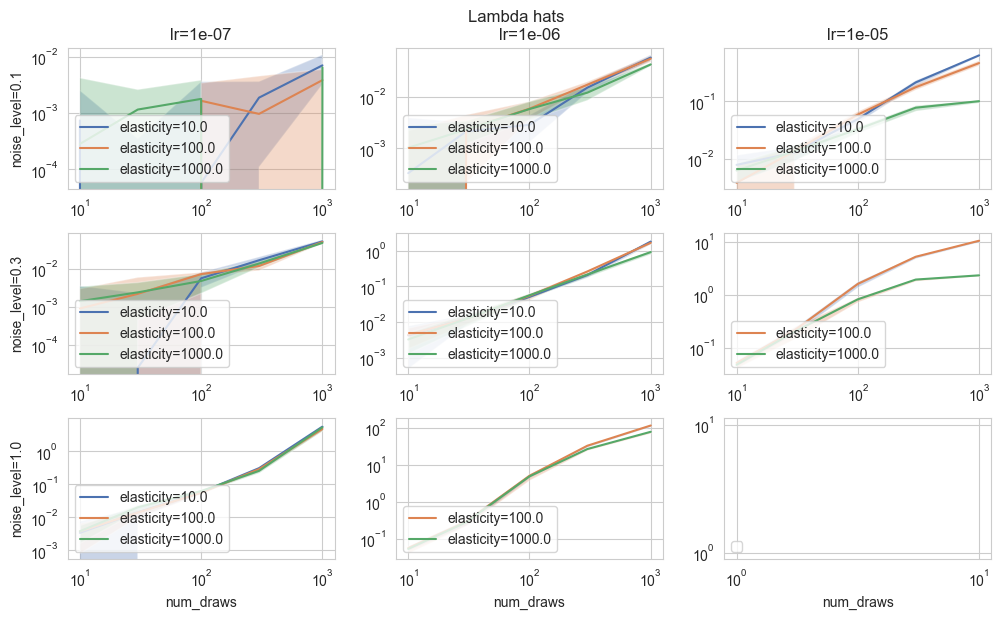

In [ ]:
NUM_PARAMS = sum(map(lambda x: x.numel(), learner.model.parameters()))


def plot_rlct_grid(
    df,
    col_axis: str,
    row_axis: str,
    label_axis: str,
    x_axis: str,
    title: str,
    logscale: bool = True,
    inset=False,
    figsize=(10, 6),
):
    cols = df[col_axis].unique()
    rows = df[row_axis].unique()
    labels = df[label_axis].unique()
    xs = df[x_axis].unique()

    # Define the colors for each w value
    colors = [PRIMARY, SECONDARY, TERTIARY]

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(len(rows), len(cols), figsize=figsize)

    if len(rows) == 1 and len(cols) == 1:
        axes = np.array([[axes]])
    elif len(rows) == 1:
        axes = axes.reshape(1, -1)
    elif len(cols) == 1:
        axes = axes.reshape(-1, 1)

    fig.suptitle(title)
    fig.tight_layout()

    # Iterate through the unique gammas
    for i, col in enumerate(cols):
        for j, row in enumerate(rows):
            axes[j, 0].set_ylabel(f"{row_axis}={row}")
            axes[0, i].set_title(f"{col_axis}={col}")
            axes[-1, i].set_xlabel(x_axis)

            ax = axes[j, i]

            for k, label in enumerate(labels):
                data = df[(df[col_axis] == col) & (df[label_axis] == label) & (df[row_axis] == row)]
                color = colors[k]

                rlct_mean = data["rlct/mean"]
                rlct_std = data["rlct/std"]

                if rlct_mean.max() > NUM_PARAMS:
                    continue

                # Plot the training error against the number of steps
                ax.plot(data[x_axis], rlct_mean, color=color, label=f"{label_axis}={label}")
                ax.fill_between(xs, rlct_mean - rlct_std, rlct_mean + rlct_std, alpha=0.3)

            if logscale:
                ax.set_yscale("log")
                ax.set_xscale("log")

            ax.legend(loc="lower left")

    plt.show()


# lr, num_draws, noise_level, elasticity
plot_rlct_grid(
    grid_search,
    col_axis="lr",
    row_axis="noise_level",
    x_axis="num_draws",
    label_axis="elasticity",
    title="Lambda hats",
)

In [ ]:
checkpoint_steps = sorted(
    list(
        map(
            lambda filename: int(str(filename).split("/")[-1].split(".")[0]),
            CHECKPOINTS_PATH.glob("*.pt"),
        )
    )
)
evals_over_time = eval_rlcts_over_time(
    learner,
    checkpoint_steps,
    num_draws=1000,
    num_chains=1,
    num_cores=NUM_CORES,
    lr=1e-6,
    noise_level=1.0,
    weight_decay=3e-7,
    elasticity=100.0,
    repeats=5,
    pbar=True,
)

rlct/0,▁
rlct/1,▁
rlct/2,▁
rlct/3,▁
rlct/4,▁
rlct/mean,▁
rlct/std,▁
rlct/0,-1090544.10238
rlct/1,4974583126.84238
rlct/2,-1095200.19739
rlct/3,464535469.37144


Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.44it/s]


rlct/0: -1076022.612389441
rlct/1: -1054982.6960950864
rlct/2: 66154327.386090904
rlct/3: -1111001.9574656803
rlct/4: 3782366701.3189497
rlct/mean: 769055804.2878181
rlct/std: 1506880460.6121142



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.74it/s]


rlct/0: -958250.7928802938
rlct/1: -1118475.4288528177
rlct/2: 2.1412674231859354e+18
rlct/3: 8957218978.728872
rlct/4: -1055052.6100986358
rlct/mean: 4.2825348642800454e+17
rlct/std: 8.565069683789654e+17



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.23it/s]


rlct/0: 590806735691404.1
rlct/1: 23154678116733.12
rlct/2: 455390776642.02515
rlct/3: 4.006420555579203e+16
rlct/4: 18513385509.090744
rlct/mean: 8135728174752464.0
rlct/std: 1.5965837222615244e+16



Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.42it/s]


rlct/0: 84420522265905.47
rlct/1: 78208507879795.12
rlct/2: 10585671937732.695
rlct/3: 144937915223922.78
rlct/4: 725232559101.8042
rlct/mean: 63775569973291.58
rlct/std: 52964819152785.33



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.16it/s]


rlct/0: 20827003100251.957
rlct/1: 5.9100261075731e+16
rlct/2: 1.546139953995687e+31
rlct/3: 1269000336089450.5
rlct/4: 1923250140393970.0
rlct/mean: 3.0922799079913867e+30
rlct/std: 6.184559815982742e+30



Chain 0: 100%|██████████| 1000/1000 [01:21<00:00, 12.20it/s]


rlct/0: 1.1624082032980454e+24
rlct/1: 2.2314989529901013e+20
rlct/2: 294535153766.3506
rlct/3: 3.2678892621509212e+16
rlct/4: 7.960900255446852e+21
rlct/mean: 2.3411845722559566e+23
rlct/std: 4.641549303314312e+23



Chain 0: 100%|██████████| 1000/1000 [01:22<00:00, 12.15it/s]


rlct/0: 354940006340040.56
rlct/1: 9.778278004969368e+17
rlct/2: 4.602720081154702e+16
rlct/3: 2295597540684887.0
rlct/4: 3.360172557566105e+17
rlct/mean: 2.7250455892242387e+17
rlct/std: 3.741350102271585e+17



Chain 0: 100%|██████████| 1000/1000 [01:21<00:00, 12.30it/s]


rlct/0: 68726027149.83414
rlct/1: 3.1354085842839204e+18
rlct/2: 34831748508.905136
rlct/3: 1748511379291866.5
rlct/4: 1053056108566956.0
rlct/mean: 6.27642051065911e+17
rlct/std: 1.253883442373285e+18



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.08it/s]


rlct/0: 662328791590129.9
rlct/1: 2.6424305666599336e+33
rlct/2: 6.682207732939501e+16
rlct/3: 262087912930.4793
rlct/4: 1968866495066.6123
rlct/mean: 5.284861133319867e+32
rlct/std: 1.0569722266639735e+33



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.04it/s]


rlct/0: -7265.708729567356
rlct/1: -6604.494732025537
rlct/2: -5923.446941951286
rlct/3: -7352.3616086739785
rlct/4: -6036.206155893416
rlct/mean: -6636.443633622315
rlct/std: 596.3527734980731



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.76it/s]


rlct/0: 1454.8972983902186
rlct/1: 1476.7806499208393
rlct/2: 1455.2836098875869
rlct/3: 1530.3417783910963
rlct/4: 1448.3330626422
rlct/mean: 1473.1272798463883
rlct/std: 30.173922333308553



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.12it/s]


rlct/0: -5036.406985572983
rlct/1: -5730.672989143792
rlct/2: -4296.196262934319
rlct/3: -5121.183947133264
rlct/4: -3035.1845718373606
rlct/mean: -4643.928951324344
rlct/std: 924.3160112466168



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.12it/s]


rlct/0: 1419.6363178528725
rlct/1: 1435.8964783549848
rlct/2: 1518.6668765346983
rlct/3: 1470.5792436720358
rlct/4: 1467.0745722036413
rlct/mean: 1462.3706977236466
rlct/std: 34.01728362040662



Chain 0: 100%|██████████| 1000/1000 [01:19<00:00, 12.62it/s]


rlct/0: -10361.076790363493
rlct/1: -10476.652976339836
rlct/2: -8036.012993279445
rlct/3: -15301.839163069573
rlct/4: -9474.768156493736
rlct/mean: -10730.070015909218
rlct/std: 2446.8418555682274



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.91it/s]


rlct/0: 1270.346132816964
rlct/1: 1270.497787186347
rlct/2: 1271.9352847354464
rlct/3: 1288.7489116387997
rlct/4: 1275.0607393170733
rlct/mean: 1275.317771138926
rlct/std: 6.926070280643061



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.98it/s]


rlct/0: 1295.8866343373154
rlct/1: 1318.7114394592938
rlct/2: 1318.070603913546
rlct/3: 1338.9617807097038
rlct/4: 1336.3498411731623
rlct/mean: 1321.5960599186042
rlct/std: 15.498172530072567



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.97it/s]


rlct/0: 282.0437021465578
rlct/1: 101.32662996142261
rlct/2: 214.7435427770518
rlct/3: 214.31041423659883
rlct/4: 260.89862698512724
rlct/mean: 214.66458322135162
rlct/std: 62.487047920859325



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.77it/s]


rlct/0: 1507.5791926550598
rlct/1: 1512.9637428113374
rlct/2: 1520.6306315007912
rlct/3: 1504.50117619174
rlct/4: 1490.787597326559
rlct/mean: 1507.2924680970975
rlct/std: 9.90307265946522



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.02it/s]


rlct/0: -199.54340434363567
rlct/1: -50.629741053882874
rlct/2: -146.98613514472413
rlct/3: -104.43176036355429
rlct/4: -122.61175760317155
rlct/mean: -124.8405597017937
rlct/std: 48.98912892244188



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.95it/s]


rlct/0: 1408.1353288233636
rlct/1: 1380.079104211469
rlct/2: 1430.7869840220712
rlct/3: 1382.4383798504014
rlct/4: 1448.3311959583928
rlct/mean: 1409.9541985731396
rlct/std: 26.682386355560137



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.01it/s]


rlct/0: 5.483639585088347e+23
rlct/1: 3.0666053836780425e+30
rlct/2: 1.3796783843794215e+25
rlct/3: 9.722619103723534e+17
rlct/4: 7.111754224427093e+19
rlct/mean: 6.133239457795869e+29
rlct/std: 1.2266407189605763e+30



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.90it/s]


rlct/0: 533.4241032642008
rlct/1: 577.6710825359023
rlct/2: 544.5751652302604
rlct/3: 594.9126226733525
rlct/4: 612.9391987537449
rlct/mean: 572.7044344914923
rlct/std: 29.902868360254736



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.29it/s]


rlct/0: 1390.8921642681453
rlct/1: 1381.7111230832893
rlct/2: 1437.5108479560074
rlct/3: 1417.9499149344372
rlct/4: 1379.4197905281324
rlct/mean: 1401.4967681540024
rlct/std: 22.62318411938095



Chain 0: 100%|██████████| 1000/1000 [17:27<00:00,  1.05s/it]  


rlct/0: 231.13689501912282
rlct/1: 170.78583218649567
rlct/2: 255.24101268152776
rlct/3: 216.5854136649507
rlct/4: 236.9549425962463
rlct/mean: 222.14081922966867
rlct/std: 28.51037587431371



Chain 0: 100%|██████████| 1000/1000 [13:20<00:00,  1.25it/s]   


rlct/0: 1417.4001303317102
rlct/1: 1384.1430993897907
rlct/2: 1435.2247368926471
rlct/3: 1394.2168772391633
rlct/4: 1402.9316955155084
rlct/mean: 1406.783307873764
rlct/std: 17.9274144292477



Chain 0: 100%|██████████| 1000/1000 [17:23<00:00,  1.04s/it]   


rlct/0: 1.0097719535856591e+20
rlct/1: 1.2577857278534722e+30
rlct/2: 1.3085163365203768e+18
rlct/3: 3.2534778985792668e+16
rlct/4: 1051.6265640784527
rlct/mean: 2.515571455911581e+29
rlct/std: 5.0311429113115706e+29



Chain 0: 100%|██████████| 1000/1000 [15:21<00:00,  1.09it/s]   


rlct/0: 409.89332274801035
rlct/1: 360.95882749233584
rlct/2: 382.3064749238547
rlct/3: 448.3521533267589
rlct/4: 427.7341770517238
rlct/mean: 405.8489911085368
rlct/std: 31.21286157506784



Chain 0: 100%|██████████| 1000/1000 [22:51<00:00,  1.37s/it]   


rlct/0: 1346.2521014404563
rlct/1: 1377.87945941445
rlct/2: 1344.786543883252
rlct/3: 1339.9372936155912
rlct/4: 1346.347664207438
rlct/mean: 1351.0406125122377
rlct/std: 13.621118676916165



Chain 0: 100%|██████████| 1000/1000 [58:35<00:00,  3.52s/it]  


rlct/0: 1.7454710715271249e+21
rlct/1: 982.015456135878
rlct/2: 8.419612786675968e+18
rlct/3: 1.2486993446262464e+17
rlct/4: 1012.3825084351506
rlct/mean: 3.5080311084965265e+20
rlct/std: 6.973415309733185e+20



Chain 0: 100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


rlct/0: -1437.5807819493302
rlct/1: -2125.632843541254
rlct/2: -2728.1212538536265
rlct/3: -2678.228804418359
rlct/4: -1741.786167522736
rlct/mean: -2142.2699702570612
rlct/std: 507.4888217021126



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.26it/s]


rlct/0: -6555.625780901129
rlct/1: -5477.178414174388
rlct/2: -14252.172089706826
rlct/3: -8616.514161838071
rlct/4: -7496.949160653056
rlct/mean: -8479.687921454695
rlct/std: 3066.6968818838645



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.85it/s]


rlct/0: -18616.59414468133
rlct/1: -15725.008284727051
rlct/2: -17115.767220267375
rlct/3: 61820009383468.22
rlct/4: -17826.24543644904
rlct/mean: 12364001862836.922
rlct/std: 24728003760315.65



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.75it/s]


rlct/0: 4.381866597260994e+17
rlct/1: 856451242028.7047
rlct/2: 1105511662166232.4
rlct/3: 1111000345789897.2
rlct/4: 12946162896.413742
rlct/mean: 8.808080822629208e+16
rlct/std: 1.750536268413022e+17



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.72it/s]


rlct/0: -7289.619333509876
rlct/1: -24359.5318161417
rlct/2: -11124.433489246172
rlct/3: -12325.587236049227
rlct/4: -17062.851275831996
rlct/mean: -14432.404630155794
rlct/std: 5862.897545031325



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.87it/s]


rlct/0: -14022.801332259865
rlct/1: -14135.034134380734
rlct/2: -24689.215972570586
rlct/3: -20335.78342920171
rlct/4: -17010.016978991254
rlct/mean: -18038.57036948083
rlct/std: 4047.9672171542816



Chain 0: 100%|██████████| 1000/1000 [01:19<00:00, 12.51it/s]


rlct/0: -14033.89177926648
rlct/1: -11723.179526085722
rlct/2: -14513.40328266907
rlct/3: -9006.824467261902
rlct/4: -9925.53898044332
rlct/mean: -11840.5676071453
rlct/std: 2175.5889436133293



Chain 0: 100%|██████████| 1000/1000 [01:23<00:00, 12.01it/s]


rlct/0: -4238.135536426667
rlct/1: -4854.658654506619
rlct/2: -9411.048809541337
rlct/3: -4466.750752818276
rlct/4: -8146.396866693593
rlct/mean: -6223.398123997299
rlct/std: 2133.5213296838792



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.10it/s]


rlct/0: -13003.1482698285
rlct/1: -14856.286541973393
rlct/2: -19103.205760838155
rlct/3: -7042.595298882686
rlct/4: -11194.747919288666
rlct/mean: -13039.99675816228
rlct/std: 3985.888541871995



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.15it/s]


rlct/0: -7800.818402034671
rlct/1: -15161.127673241888
rlct/2: -4202.518157179993
rlct/3: -11614.008587053466
rlct/4: -14861.47922088476
rlct/mean: -10727.990408078955
rlct/std: 4211.260809806537



Chain 0: 100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]


rlct/0: -5340.293456203714
rlct/1: -6400.9188311885355
rlct/2: -2204.912445923657
rlct/3: -2934.4671686109405
rlct/4: -2605.66399638572
rlct/mean: -3897.2511796625136
rlct/std: 1661.919589801944



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.13it/s]


rlct/0: -6818.287954169025
rlct/1: -4971.803052743925
rlct/2: -9566.990195865354
rlct/3: -7442.646987766801
rlct/4: -3994.443945518843
rlct/mean: -6558.83442721279
rlct/std: 1948.9591596270975



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.85it/s]


rlct/0: 315.55701800864114
rlct/1: 338.66260209031486
rlct/2: 296.5628704589195
rlct/3: 318.6759982438302
rlct/4: 335.5787222932977
rlct/mean: 321.00744221900067
rlct/std: 15.209909379751462



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.84it/s]


rlct/0: 286.5472715439491
rlct/1: 285.8029195697275
rlct/2: 274.9975062933832
rlct/3: 288.392236692658
rlct/4: 286.6183108816462
rlct/mean: 284.4716489962728
rlct/std: 4.812879291859435



Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.49it/s]


rlct/0: 155.79698101761696
rlct/1: 156.0542219451248
rlct/2: 162.5161991316121
rlct/3: 155.37279911478302
rlct/4: 161.79870218102928
rlct/mean: 158.30778067803323
rlct/std: 3.158926320588575



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s]


rlct/0: 99.9770820642595
rlct/1: 95.17147823698298
rlct/2: 96.59852795557077
rlct/3: 92.72011400077947
rlct/4: 98.68258512432763
rlct/mean: 96.62995747638406
rlct/std: 2.5624811717604086



Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.47it/s]


rlct/0: -16551.50614650968
rlct/1: 1.7236255558097418e+17
rlct/2: -14696.544557372745
rlct/3: -8490.085228845264
rlct/4: 215577395986720.44
rlct/mean: 3.4515626595384236e+16
rlct/std: 6.892351506366763e+16



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.11it/s]


rlct/0: -1637.3936381254775
rlct/1: -3610.522614465434
rlct/2: -1355.7769916293846
rlct/3: -1452.5585550966857
rlct/4: -1646.13926702342
rlct/mean: -1940.4782132680805
rlct/std: 842.31645933726



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.04it/s]


rlct/0: 254.8712226593964
rlct/1: 249.90454585001618
rlct/2: 237.95059831632716
rlct/3: 235.1956513748294
rlct/4: 238.85446881748254
rlct/mean: 243.35529740361034
rlct/std: 7.636193334514078



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.15it/s]


rlct/0: 176.92631018142225
rlct/1: 173.50322398145235
rlct/2: 186.49969255025246
rlct/3: 189.97528763200276
rlct/4: 184.85593195909516
rlct/mean: 182.352089260845
rlct/std: 6.1534785294408705



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.05it/s]


rlct/0: 108.11717552673021
rlct/1: 104.09569290744236
rlct/2: 105.57215502295014
rlct/3: 105.73654861964613
rlct/4: 117.46820320364625
rlct/mean: 108.19795505608302
rlct/std: 4.810944361458892



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.31it/s]


rlct/0: 74.28043357021342
rlct/1: 70.12726694794402
rlct/2: 76.64654363544622
rlct/3: 73.3394681128684
rlct/4: 69.25282951776222
rlct/mean: 72.72930835684686
rlct/std: 2.7195419171456603



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.15it/s]


rlct/0: -3291.24752501639
rlct/1: -8749.216553621867
rlct/2: -20251.393889612445
rlct/3: 1.1122731332677074e+37
rlct/4: 977866546590703.4
rlct/mean: 2.2245462665354148e+36
rlct/std: 4.4490925330708296e+36



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.98it/s]


rlct/0: 194.85787505794116
rlct/1: 189.27240360930205
rlct/2: 175.61715647850073
rlct/3: 184.15452799176296
rlct/4: 197.62212786029042
rlct/mean: 188.30481819955946
rlct/std: 7.859932617843884



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.09it/s]


rlct/0: 191.48809450954573
rlct/1: 205.1204703986935
rlct/2: 191.99596996741798
rlct/3: 208.96190401352806
rlct/4: 188.22776092090783
rlct/mean: 197.15883996201862
rlct/std: 8.261678202649632



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.94it/s]


rlct/0: 131.29886752174139
rlct/1: 128.58370326102556
rlct/2: 115.62912220885954
rlct/3: 120.10238964789997
rlct/4: 124.13307746531551
rlct/mean: 123.9494320209684
rlct/std: 5.648923581450391



Chain 0: 100%|██████████| 1000/1000 [01:21<00:00, 12.23it/s]


rlct/0: 79.14331234718918
rlct/1: 81.26962747570023
rlct/2: 81.76573304604538
rlct/3: 78.05654303920794
rlct/4: 75.97892481992888
rlct/mean: 79.24282814561433
rlct/std: 2.123356085459717



Chain 0: 100%|██████████| 1000/1000 [01:20<00:00, 12.45it/s]


rlct/0: 68.4155763447219
rlct/1: 62.92091902054034
rlct/2: 69.04064886674695
rlct/3: 67.71695129840623
rlct/4: 65.59325785721363
rlct/mean: 66.7374706775258
rlct/std: 2.2340698385173723



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.05it/s]


rlct/0: 156.47916871314547
rlct/1: 156.5274210768969
rlct/2: 132.51967901870557
rlct/3: 159.60521882163107
rlct/4: 139.65355069701084
rlct/mean: 148.957007665478
rlct/std: 10.807576522782387



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.33it/s]


rlct/0: 228.7532895756783
rlct/1: 230.82837353418444
rlct/2: 226.66875648851675
rlct/3: 220.1463367461285
rlct/4: 221.89263658711198
rlct/mean: 225.65787858632402
rlct/std: 4.047013765750324



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.94it/s]


rlct/0: 151.285814584599
rlct/1: 146.71119256215027
rlct/2: 145.93778229901628
rlct/3: 139.99235590073033
rlct/4: 147.5061254236215
rlct/mean: 146.28665415402347
rlct/std: 3.6441418776059527



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.03it/s]


rlct/0: 91.71252421219825
rlct/1: 92.40860748398369
rlct/2: 83.87391393178805
rlct/3: 95.12601174714693
rlct/4: 95.49667785917495
rlct/mean: 91.72354704685837
rlct/std: 4.192837977078755



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.74it/s]


rlct/0: 76.10447708648236
rlct/1: 72.75727705456808
rlct/2: 71.66865795183338
rlct/3: 73.3314298336461
rlct/4: 66.77705360703406
rlct/mean: 72.1277791067128
rlct/std: 3.049597519964707



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]


rlct/0: 29.68085104061136
rlct/1: 55.1843355410207
rlct/2: 104.98373365393671
rlct/3: 38.5038801189725
rlct/4: 43.95375805871884
rlct/mean: 54.461311682652024
rlct/std: 26.578778829153883



Chain 0: 100%|██████████| 1000/1000 [01:19<00:00, 12.57it/s]


rlct/0: 227.3988146717272
rlct/1: 223.34141085963446
rlct/2: 211.88649627058092
rlct/3: 207.19046453550726
rlct/4: 209.62458728105867
rlct/mean: 215.8883547237017
rlct/std: 7.986760061009499



Chain 0: 100%|██████████| 1000/1000 [01:22<00:00, 12.14it/s]


rlct/0: 154.14105305210262
rlct/1: 165.44847506689584
rlct/2: 158.88738681519203
rlct/3: 161.29545214455675
rlct/4: 148.87965756305906
rlct/mean: 157.73040492836125
rlct/std: 5.74170621365291



Chain 0: 100%|██████████| 1000/1000 [01:20<00:00, 12.41it/s]


rlct/0: 105.88419528375859
rlct/1: 97.96076923915574
rlct/2: 96.44383241335602
rlct/3: 96.7335474218333
rlct/4: 94.71202919597182
rlct/mean: 98.34687471081509
rlct/std: 3.908881571463388



Chain 0: 100%|██████████| 1000/1000 [01:20<00:00, 12.45it/s]


rlct/0: 70.71192006511976
rlct/1: 66.99074074649356
rlct/2: 78.34671250231114
rlct/3: 74.00284521965939
rlct/4: 81.00123086700792
rlct/mean: 74.21068988011835
rlct/std: 5.052333819914786



Chain 0: 100%|██████████| 1000/1000 [01:19<00:00, 12.53it/s]


rlct/0: 101.19503605699234
rlct/1: 97.09096041259535
rlct/2: 96.72762641231279
rlct/3: 101.207435729675
rlct/4: 118.62255197969269
rlct/mean: 102.96872211825364
rlct/std: 8.059650607769573



Chain 0: 100%|██████████| 1000/1000 [01:21<00:00, 12.27it/s]


rlct/0: 204.8527020130123
rlct/1: 205.26350834760208
rlct/2: 214.42105761888425
rlct/3: 217.5685301255056
rlct/4: 222.15433176194614
rlct/mean: 212.85202597339008
rlct/std: 6.82370791117641



Chain 0: 100%|██████████| 1000/1000 [01:19<00:00, 12.59it/s]


rlct/0: 174.78209768039397
rlct/1: 174.68639131583706
rlct/2: 184.5064036972138
rlct/3: 177.29072333432796
rlct/4: 192.54873462591814
rlct/mean: 180.7628701307382
rlct/std: 6.894485952246673



Chain 0: 100%|██████████| 1000/1000 [01:20<00:00, 12.37it/s]


rlct/0: 119.73840637047394
rlct/1: 121.87240624827196
rlct/2: 122.02392555326021
rlct/3: 115.68784021617786
rlct/4: 115.78663921194155
rlct/mean: 119.0218435200251
rlct/std: 2.801206585230489



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.84it/s]


rlct/0: 80.19327750107233
rlct/1: 86.16222762678983
rlct/2: 83.62304368818874
rlct/3: 84.01828616877253
rlct/4: 91.84326270723557
rlct/mean: 85.1680195384118
rlct/std: 3.8471864166695022



Chain 0: 100%|██████████| 1000/1000 [01:29<00:00, 11.22it/s]


rlct/0: 96.50010940336723
rlct/1: 101.19540400377562
rlct/2: 95.70270664455055
rlct/3: 90.6080821139533
rlct/4: 89.50242327816123
rlct/mean: 94.7017450887616
rlct/std: 4.24722658190628



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.78it/s]


rlct/0: 213.83294668383627
rlct/1: 220.41490768819872
rlct/2: 212.3743886828836
rlct/3: 214.91347083918737
rlct/4: 210.36995902511657
rlct/mean: 214.3811345838445
rlct/std: 3.379552284290215



Chain 0: 100%|██████████| 1000/1000 [01:49<00:00,  9.12it/s]


rlct/0: 193.32202687646563
rlct/1: 210.96513074525376
rlct/2: 196.39454311269827
rlct/3: 181.75606938664075
rlct/4: 184.30003463591152
rlct/mean: 193.347560951394
rlct/std: 10.352622149454723



Chain 0: 100%|██████████| 1000/1000 [01:20<00:00, 12.43it/s]


rlct/0: 131.92906855344341
rlct/1: 130.94511953068823
rlct/2: 130.2517501854428
rlct/3: 124.24454700565086
rlct/4: 118.54391912063366
rlct/mean: 127.18288087917179
rlct/std: 5.0865344223176



Chain 0: 100%|██████████| 1000/1000 [01:19<00:00, 12.59it/s]


rlct/0: 97.38182944013309
rlct/1: 97.58266124088438
rlct/2: 95.15757415769895
rlct/3: 94.69875672663285
rlct/4: 99.80726540093261
rlct/mean: 96.92561739325637
rlct/std: 1.8454601919803635



Chain 0: 100%|██████████| 1000/1000 [01:21<00:00, 12.24it/s]


rlct/0: 118.90190135406847
rlct/1: 123.08853121462442
rlct/2: 127.93098436996038
rlct/3: 132.85894724987753
rlct/4: 112.70160126961119
rlct/mean: 123.0963930916284
rlct/std: 6.9903684636779415



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.11it/s]


rlct/0: 229.53435653386876
rlct/1: 245.52520398371
rlct/2: 236.2340508341042
rlct/3: 225.6296720519183
rlct/4: 231.46029322934652
rlct/mean: 233.67671532658954
rlct/std: 6.83744421697344



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.71it/s]


rlct/0: 188.40289663558585
rlct/1: 184.67196486430396
rlct/2: 190.11711622822904
rlct/3: 195.67129070276567
rlct/4: 205.11556634185308
rlct/mean: 192.79576695454753
rlct/std: 7.106542528181868



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.85it/s]


rlct/0: 135.37809175130533
rlct/1: 8.374483968127605e+19
rlct/2: 135.52935392084842
rlct/3: 136.38449972698092
rlct/4: 138.82192410420294
rlct/mean: 1.674896793625521e+19
rlct/std: 3.349793587251042e+19



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.98it/s]


rlct/0: 95.72178667146446
rlct/1: 99.54153802857762
rlct/2: 101.91471786346158
rlct/3: 102.70084884189863
rlct/4: 94.48272496474485
rlct/mean: 98.87232327402941
rlct/std: 3.2727992743312235



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.09it/s]


rlct/0: 144217089377423.16
rlct/1: 94.15732566720742
rlct/2: 97.95747421600169
rlct/3: 95.02118130003771
rlct/4: 114.60335865438317
rlct/mean: 28843417875564.98
rlct/std: 57686835750929.086



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.31it/s]


rlct/0: 193.4799991347446
rlct/1: 207.82442476411225
rlct/2: 195.38227302381364
rlct/3: 207.29735283429233
rlct/4: 200.87255017587773
rlct/mean: 200.9713199865681
rlct/std: 5.905096548149382



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.04it/s]


rlct/0: 176.74716259779765
rlct/1: 180.68193083081178
rlct/2: 177.2846341028347
rlct/3: 182.52866913250045
rlct/4: 177.60469544863895
rlct/mean: 178.96941842251672
rlct/std: 2.2467911480535196



Chain 0: 100%|██████████| 1000/1000 [01:13<00:00, 13.60it/s]


rlct/0: 120.57111985855003
rlct/1: 127.1594349713819
rlct/2: 128.8151474399865
rlct/3: 133.13037078234046
rlct/4: 124.40538725199967
rlct/mean: 126.8162920608517
rlct/std: 4.214152294795425



Chain 0: 100%|██████████| 1000/1000 [01:09<00:00, 14.29it/s]


rlct/0: 99.3660881192832
rlct/1: 102.55014031948984
rlct/2: 8239191825.003675
rlct/3: 104.7158124208077
rlct/4: 100.20233192173464
rlct/mean: 1647838446.3676095
rlct/std: 3295676689.318033



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.88it/s]


rlct/0: 134.23855711056453
rlct/1: 148.16239224241625
rlct/2: 138.66589927948405
rlct/3: 135.22474700843213
rlct/4: 145.3368631777584
rlct/mean: 140.32569176373107
rlct/std: 5.520026632300694



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


rlct/0: 199.01682569374628
rlct/1: 204.05993626647165
rlct/2: 195.09168428152728
rlct/3: 208.90527407619237
rlct/4: 206.8409845884635
rlct/mean: 202.7829409812802
rlct/std: 5.077803686275201



Chain 0: 100%|██████████| 1000/1000 [01:19<00:00, 12.65it/s]


rlct/0: 172.6355957716455
rlct/1: 169.95638031069623
rlct/2: 165.20593163877695
rlct/3: 156.09171113852005
rlct/4: 172.34846935560358
rlct/mean: 167.24761764304847
rlct/std: 6.180762467126145



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.33it/s]


rlct/0: 121.25295464320583
rlct/1: 4.093824615440154e+18
rlct/2: 113.93169369179728
rlct/3: 116.57209481465972
rlct/4: 110.84000624435261
rlct/mean: 8.187649230880308e+17
rlct/std: 1.6375298461760617e+18



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.18it/s]


rlct/0: 1.088072701918318e+22
rlct/1: 53718275.401278675
rlct/2: 100947687.56239423
rlct/3: 7627341955193069.0
rlct/4: 2.1188565210211953e+18
rlct/mean: 2.1765707006092627e+21
rlct/std: 4.3520782364714116e+21



Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.34it/s]


rlct/0: 130.18140849243719
rlct/1: 127.73848753107004
rlct/2: 143.48863518157523
rlct/3: 130.30311873213657
rlct/4: 124.44820817391881
rlct/mean: 131.23197162222758
rlct/std: 6.487158542935836



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.22it/s]


rlct/0: 200.81500164610537
rlct/1: 204.41799490637064
rlct/2: 196.26126766374955
rlct/3: 190.15628105254098
rlct/4: 200.0575463931414
rlct/mean: 198.34161833238159
rlct/std: 4.84379998935669



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.08it/s]


rlct/0: 150.3332263529246
rlct/1: 164.11918989889907
rlct/2: 152.19320808546144
rlct/3: 158.891300243228
rlct/4: 151.27001499029456
rlct/mean: 155.36138791416155
rlct/std: 5.314479864856062



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.25it/s]


rlct/0: 123.835849886314
rlct/1: 119.98159569836571
rlct/2: 108.7446154097702
rlct/3: 116.9165171168659
rlct/4: 2.121077313385854e+17
rlct/mean: 4.2421546267717176e+16
rlct/std: 8.484309253543411e+16



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.76it/s]


rlct/0: 412144541405367.4
rlct/1: 3635216620490.0586
rlct/2: 7.974450227524948e+27
rlct/3: 9.149332738855426e+20
rlct/4: 3.4776124512137244e+24
rlct/mean: 1.59558575098197e+27
rlct/std: 3.189432522608948e+27



Chain 0: 100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]


rlct/0: 100.02988101311568
rlct/1: 96.96143960206723
rlct/2: 105.36648645106939
rlct/3: 119.5986399443365
rlct/4: 106.0626594479086
rlct/mean: 105.60382129169948
rlct/std: 7.770217254348514



Chain 0: 100%|██████████| 1000/1000 [01:13<00:00, 13.52it/s]


rlct/0: 207.7648529203064
rlct/1: 215.76966129022443
rlct/2: 206.40205377102365
rlct/3: 199.56973094455788
rlct/4: 197.31232300126814
rlct/mean: 205.3637243854761
rlct/std: 6.534867913926041



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.31it/s]


rlct/0: 165.5106315790431
rlct/1: 166.5248222629364
rlct/2: 164.85112582453556
rlct/3: 166.26286493468126
rlct/4: 152.44594098144816
rlct/mean: 163.1190771165289
rlct/std: 5.36875893070059



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.73it/s]

rlct/0: 116.98023068550133
rlct/1: 116.56411709279675
rlct/2: 121.71716616075066
rlct/3: 116.43021858211286
rlct/4: 335981373.9496058
rlct/mean: 67196369.12826768
rlct/std: 134392502.41066912

